In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import azureml.core
import pandas as pd
import numpy as np
import logging
from azureml.core import Workspace, Experiment, Dataset
from azureml.core.compute import AmlCompute, ComputeTarget
from azureml.train.automl.run import AutoMLRun
from datetime import datetime

# recreate local variables
target_column_name, time_column_name, max_horizon = 'cnt', 'date', 14

# connect to the workspace and experiment again (iu this case I uploaded the config.json to same location)
ws = Workspace.from_config()
experiment_name = 'automl_bikeshare_forecast'
experiment = Experiment(ws,experiment_name)

# connect to the compute cluster again
amlcompute_cluster_name = "cpu-cluster"
cts = ws.compute_targets
compute_target = cts[amlcompute_cluster_name]

# connect to the dataset from within the datastore again
csv_name = 'bike-no.csv'
datastore = ws.get_default_datastore()
dataset = Dataset.Tabular.from_delimited_files(path=[(datastore,f'dataset/{csv_name}')]).with_timestamp_columns(fine_grain_timestamp=time_column_name)
dataset.to_pandas_dataframe().reset_index(drop=True)

# connect to the most recent run again
run_id = 'AutoML_acf975c6-d04c-40bf-8551-a3d01f370595'
remote_run = AutoMLRun(experiment,run_id)
remote_run

# recreate the test data
test = dataset.time_after(datetime(2012,9,1),include_boundary=True)
test.to_pandas_dataframe().head(5).reset_index(drop=True)

,instant,date,season,yr,mnth,weekday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,610,2012-09-01,3,1,9,6,2,0.753333,0.702654,0.638333,0.113187,2352,3788,6140
1,611,2012-09-02,3,1,9,0,2,0.696667,0.649000,0.815000,0.064071,2613,3197,5810
2,612,2012-09-03,3,1,9,1,1,0.707500,0.661629,0.790833,0.151121,1965,4069,6034
3,613,2012-09-04,3,1,9,2,1,0.725833,0.686888,0.755000,0.236321,867,5997,6864
4,614,2012-09-05,3,1,9,3,1,0.736667,0.708983,0.741250,0.187808,832,6280,7112


In [3]:
remote_run.get_details()

{'runId': 'AutoML_acf975c6-d04c-40bf-8551-a3d01f370595',
 'target': 'cpu-cluster',
 'status': 'Completed',
 'startTimeUtc': '2021-09-03T17:04:17.710195Z',
 'endTimeUtc': '2021-09-03T17:38:15.619382Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'normalized_root_mean_squared_error',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '3',
  'target': 'cpu-cluster',
  'AMLSettingsJsonString': '{"path":null,"name":"automl_bikeshare_forecast","subscription_id":"65881521-f775-4359-a9d9-a122ba465711","resource_group":"DevIntroDS_ResourceGroup","workspace_name":"DevIntroDS","region":"eastus","compute_target":"cpu-cluster","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"enable_batch_run":false,"enable_run_restructure":false,"start_auxiliary_runs_before_parent_complete":false,"enable_code_generation":false,"iterations":1000,"primary_m

In [5]:
best_run, fitted_model = remote_run.get_output()
fitted_model.steps

[('timeseriestransformer',
  TimeSeriesTransformer(
      pipeline_type=TimeSeriesPipelineType.FULL,
      max_horizon=14,
      use_stl=None,
      seasonality=7,
      force_time_index_features=None,
      grain_column_names=['_automl_dummy_grain_col'],
      drop_column_names=['casual', 'registered'],
      origin_time_colname='origin',
      group=None,
      country_or_region='US',
      freq='D',
      time_column_name='date',
      pipeline=Pipeline(
          memory=None,
          steps=[('drop_irrelevant_columns', DropColumns(
              drop_columns=['casual', 'registered']
          )), ('make_numeric_na_dummies', MissingDummiesTransformer(
              numerical_columns=['instant', 'season', 'yr', 'mnth', 'weekday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
          )), ('impute_na_numeric_datetime', TimeSeriesImputer(
              end=None,
              freq='D',
              impute_by_horizon=False,
              input_column=['instant', 'season', 'yr', 

In [5]:
fitted_model.named_steps['timeseriestransformer'].get_engineered_feature_names()

['_automl_target_col_WASNULL',
 'atemp',
 'atemp_WASNULL',
 'horizon_origin',
 'hum',
 'hum_WASNULL',
 'instant',
 'instant_WASNULL',
 'mnth',
 'mnth_WASNULL',
 'season',
 'season_WASNULL',
 'temp',
 'temp_WASNULL',
 'weathersit',
 'weathersit_WASNULL',
 'weekday',
 'weekday_WASNULL',
 'windspeed',
 'windspeed_WASNULL',
 'yr',
 'yr_WASNULL',
 '_automl_target_col_lag1D',
 '_automl_year',
 '_automl_year_iso',
 '_automl_half',
 '_automl_quarter',
 '_automl_month',
 '_automl_day',
 '_automl_wday',
 '_automl_qday',
 '_automl_week',
 '_automl_IsPaidTimeOff',
 '_automl_Holiday_1 day after Christmas Day',
 '_automl_Holiday_1 day after Columbus Day',
 '_automl_Holiday_1 day after Independence Day',
 '_automl_Holiday_1 day after Labor Day',
 '_automl_Holiday_1 day after Martin Luther King, Jr. Day',
 '_automl_Holiday_1 day after Memorial Day',
 "_automl_Holiday_1 day after New Year's Day",
 '_automl_Holiday_1 day after Thanksgiving',
 '_automl_Holiday_1 day after Veterans Day',
 "_automl_Holiday

In [6]:
featurization_summary = fitted_model.named_steps['timeseriestransformer'].get_featurization_summary()
pd.DataFrame.from_records(featurization_summary)

,RawFeatureName,TypeDetected,Dropped,EngineeredFeatureCount,Transformations
0,_automl_target_col,Numeric,No,2,"[ImputationMarker, Lag]"
1,atemp,Numeric,No,2,"[MedianImputer, ImputationMarker]"
2,date,DateTime,No,105,"[MaxHorizonFeaturizer, DateTimeTransformer, Da..."
3,hum,Numeric,No,2,"[MedianImputer, ImputationMarker]"
4,instant,Numeric,No,2,"[MedianImputer, ImputationMarker]"
5,mnth,Numeric,No,2,"[MedianImputer, ImputationMarker]"
6,season,Numeric,No,2,"[MedianImputer, ImputationMarker]"
7,temp,Numeric,No,2,"[MedianImputer, ImputationMarker]"
8,weathersit,Numeric,No,2,"[MedianImputer, ImputationMarker]"
9,weekday,Numeric,No,2,"[MedianImputer, ImputationMarker]"


In [7]:
from run_forecast import run_rolling_forecast

test_experiment = Experiment(ws,experiment_name + '_test')
remote_run = run_rolling_forecast(
    test_experiment,
    compute_target,
    best_run,
    test,
    max_horizon,
    target_column_name,
    time_column_name
)
remote_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl_bikeshare_forecast_test,automl_bikeshare_forecast_test_1630691543_7e73e341,azureml.scriptrun,Preparing,Link to Azure Machine Learning studio,Link to Documentation


In [8]:
remote_run.wait_for_completion(show_output=False)

{'runId': 'automl_bikeshare_forecast_test_1630691543_7e73e341',
 'target': 'cpu-cluster',
 'status': 'Finalizing',
 'startTimeUtc': '2021-09-03T17:52:29.307334Z',
 'properties': {'_azureml.ComputeTargetType': 'amlcompute',
  'ContentSnapshotId': '8804af66-2640-4365-ac22-4485b4d9e367',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': '48182d0b-fa18-40f8-b1b9-09b967292f7b'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'test_data', 'mechanism': 'Direct'}}],
 'outputDatasets': [],
 'runDefinition': {'script': 'forecasting_script.py',
  'command': '',
  'useAbsolutePath': False,
  'arguments': ['--max_horizon',
   '14',
   '--target_column_name',
   'cnt',
   '--time_column_name',
   'date',
   '--frequency',
   'D'],
  'sourceDirectoryDataStore': None,
  'framework': 'Python',
  'communicator': 'None',
  'target': 'cpu-cluster',
  'dataReferences': {},
  'data': {'test_data':

In [10]:
pred_csv_name = 'predictions.csv'
remote_run.download_file(f'outputs/{pred_csv_name}',pred_csv_name)
df_all = pd.read_csv(pred_csv_name)

In [11]:
from metrics_helper import MAPE, APE
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from automl.client.core.common import constants

print("Simple forecasting model")
rmse = np.sqrt(mean_squared_error(df_all[target_column_name],df_all['predicted']))
print(f"[Test Data] \nRoot Mean Squared Error: {rmse:.2f}")
mae = mean_absolute_error(df_all[target_column_name],df_all['predicted'])
print(f"mean_absolute_error score: {mae:.2f}")
mape = MAPE(df_all[target_column_name],df_all['predicted'])
print(f"MAPE: {mape:.2f}")

Simple forecasting model
[Test Data] 
Root Mean Squared Error: 1178.59
mean_absolute_error score: 855.45
MAPE: 208.33


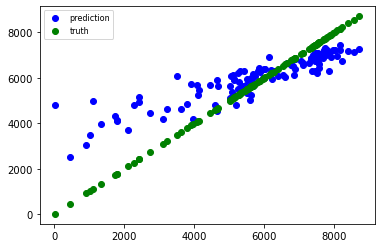

In [12]:
# plot outputs
%matplotlib inline
test_pred = plt.scatter(df_all[target_column_name],df_all['predicted'],color='b')
test_test = plt.scatter(df_all[target_column_name],df_all[target_column_name],color='g')
plt.legend((test_pred,test_test),('prediction','truth'),loc='upper left',fontsize=8)
plt.show();

In [13]:
df_all.groupby('horizon_origin').apply(
    lambda df: pd.Series({
        'MAPE': MAPE(df[target_column_name],df['predicted']),
        'RMSE': np.sqrt(mean_squared_error(df[target_column_name],df['predicted'])),
        'MAE': mean_absolute_error(df[target_column_name],df['predicted'])
    })
)

,MAPE,RMSE,MAE
horizon_origin,,,
1,38.80,1527.24,1310.89
2,37.11,1350.64,1027.50
3,2455.20,1772.01,969.31
4,79.25,1747.10,1294.55
5,58.73,859.40,637.07
6,13.75,743.70,541.45
7,10.67,668.04,565.85
8,31.83,1171.58,929.53
9,34.25,1429.57,1199.35


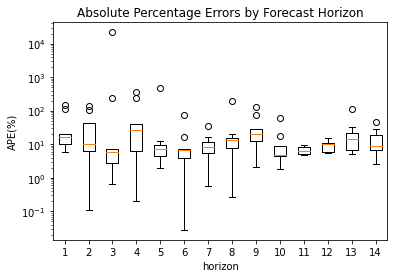

In [14]:
df_all_APE = df_all.assign(APE=APE(df_all[target_column_name],df_all['predicted']))
APEs = [df_all_APE[df_all['horizon_origin']==h].APE.values for h in range(1,max_horizon+1)]

plt.boxplot(APEs)
plt.yscale('log')
plt.xlabel('horizon')
plt.ylabel('APE(%)')
plt.title('Absolute Percentage Errors by Forecast Horizon')
plt.show();

In [15]:
run_id = 'AutoML_acf975c6-d04c-40bf-8551-a3d01f370595'
training_run = AutoMLRun(experiment,run_id)
training_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl_bikeshare_forecast,AutoML_acf975c6-d04c-40bf-8551-a3d01f370595,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [16]:
best_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl_bikeshare_forecast,AutoML_acf975c6-d04c-40bf-8551-a3d01f370595_47,azureml.scriptrun,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [17]:
model_name = best_run.properties['model_name']
model_name

'AutoMLacf975c6d47'

In [18]:
script_file_name = 'inference/score.py'
best_run.download_file('outputs/scoring_file_v_1_0_0.py',script_file_name)

In [19]:
description = "Bike Share AutoML Model"
model = training_run.register_model(model_name=model_name,description=description,tags=None)
print(training_run.model_id)

AutoMLacf975c6d47


In [20]:
from azureml.core.model import InferenceConfig, Model
from azureml.core.webservice import AciWebservice, Webservice
from azureml.core.environment import Environment

inference_config = InferenceConfig(
    entry_script=script_file_name,
    environment=best_run.get_environment()
)
aciconfig = AciWebservice.deploy_configuration(
    cpu_cores=1,
    memory_gb=1,
    tags={'type':'automl-forecasting'},
    description='sample service for AutoML Forecasting'
)

aci_service_name = 'automl-bike-sharing'
print(aci_service_name)
aci_service = Model.deploy(ws,aci_service_name,[model],inference_config,aciconfig)
aci_service.wait_for_deployment(True)
print(aci_service.state)

automl-bike-sharing
Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-09-03 19:01:00+00:00 Creating Container Registry if not exists.
2021-09-03 19:01:01+00:00 Registering the environment.
2021-09-03 19:01:01+00:00 Use the existing image.
2021-09-03 19:01:01+00:00 Generating deployment configuration.
2021-09-03 19:01:02+00:00 Submitting deployment to compute.
2021-09-03 19:01:06+00:00 Checking the status of deployment automl-bike-sharing..
2021-09-03 19:08:13+00:00 Checking the status of inference endpoint automl-bike-sharing.
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


In [73]:
test_df = pd.read_csv('./bike-no-horizon.csv')
# https://raw.githubusercontent.com/microsoft/c9-dev-intro-data-science/main/regression-with-bikes/bike-no-horizon.csv
feature_cols = ["date",
 "instant", 
 "season", 
 "yr", 
 "mnth", 
 "weekday", 
 "weathersit", 
 "temp", 
 "atemp", 
 "hum", 
 "windspeed", 
 "casual", 
 "registered"]
 # score.py is formatted in a certain way on input youtube videos do not take that into account for order of columns
test_df_notarget = test_df[feature_cols]
test_df_notarget

,date,instant,season,yr,mnth,weekday,weathersit,temp,atemp,hum,windspeed,casual,registered
0,9/1/2012,610,3,1,9,6,2,0.75,0.70,0.64,0.11,2352,3788
1,9/2/2012,611,3,1,9,0,2,0.70,0.65,0.81,0.06,2613,3197
2,9/3/2012,612,3,1,9,1,1,0.71,0.66,0.79,0.15,1965,4069
3,9/4/2012,613,3,1,9,2,1,0.73,0.69,0.76,0.24,867,5997
4,9/5/2012,614,3,1,9,3,1,0.74,0.71,0.74,0.19,832,6280
5,9/6/2012,615,3,1,9,4,2,0.70,0.66,0.81,0.14,611,5592
6,9/7/2012,616,3,1,9,5,1,0.70,0.66,0.74,0.17,1045,6459
7,9/8/2012,617,3,1,9,6,2,0.66,0.61,0.80,0.28,1557,4419
8,9/9/2012,618,3,1,9,0,1,0.61,0.58,0.55,0.22,2570,5657
9,9/10/2012,619,3,1,9,1,1,0.58,0.57,0.50,0.26,1118,6407


In [74]:
import json

test_sample = json.dumps({'data': test_df_notarget.to_dict(orient='records')})
response = aci_service.run(input_data = test_sample)
response

'{"forecast": [6914.92753782131, 6310.973865270732, 6379.610642688925, 6850.0772635456115, 6660.422438223053, 6339.125939718988, 7044.83083656605, 5992.063668675447, 6764.191193489599, 6847.271210515605, 7021.461129873693, 7121.063550020697, 7240.201059397811, 7238.035235699873], "index": [{"date": 1346457600000, "_automl_dummy_grain_col": "_automl_dummy_grain_col", "origin": 1346371200000}, {"date": 1346544000000, "_automl_dummy_grain_col": "_automl_dummy_grain_col", "origin": 1346371200000}, {"date": 1346630400000, "_automl_dummy_grain_col": "_automl_dummy_grain_col", "origin": 1346371200000}, {"date": 1346716800000, "_automl_dummy_grain_col": "_automl_dummy_grain_col", "origin": 1346371200000}, {"date": 1346803200000, "_automl_dummy_grain_col": "_automl_dummy_grain_col", "origin": 1346371200000}, {"date": 1346889600000, "_automl_dummy_grain_col": "_automl_dummy_grain_col", "origin": 1346371200000}, {"date": 1346976000000, "_automl_dummy_grain_col": "_automl_dummy_grain_col", "origin

In [75]:
res_dict = json.loads(response)
y_fcst_all = pd.DataFrame(res_dict['index'])
y_fcst_all[time_column_name] = pd.to_datetime(y_fcst_all[time_column_name], unit='ms')
y_fcst_all['forecast'] = res_dict['forecast']

In [76]:
webservice_df = pd.DataFrame({'Truth': test_df['cnt'],'Forecast': y_fcst_all['forecast']})
webservice_df['APE'] = APE(webservice_df['Truth'], webservice_df['Forecast'])
webservice_df

,Truth,Forecast,APE
0,6140,6914.93,12.62
1,5810,6310.97,8.62
2,6034,6379.61,5.73
3,6864,6850.08,0.20
4,7112,6660.42,6.35
5,6203,6339.13,2.19
6,7504,7044.83,6.12
7,5976,5992.06,0.27
8,8227,6764.19,17.78
9,7525,6847.27,9.01
